In [40]:
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import fsolve, curve_fit
import pandas as pd
from gekko import GEKKO
from scipy.stats import norm
from scipy import stats
import sympy as sp

In [49]:
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 100
matplotlib.rcParams['figure.figsize'] = [4.0, 3.0]
matplotlib.rcParams['font.size'] = 8

# Data processing

In [15]:
data = pd.read_excel("data/triang_dist_param.xlsx", index_col = 0)
data_electrolysis = pd.read_excel("data/triang_dist_param_electrolysis.xlsx", index_col = 0)
data_other = pd.read_excel("data/triang_dist_param_us.xlsx", index_col = 0)
hist = pd.read_csv("data/Historical_data_summary.csv", names = ["tech", "year", "c_inv", "cap"], header=0)
hist_electrolysis = pd.read_csv("data/Historical_electrolysis.csv", names = ["tech", "year", "c_inv", "cap"], header=0, index_col=False)
pred = pd.read_csv("data/Cost_data_summary_V2.csv", names = ["tech", "year", "cost_ratio", "c_inv", "cap", "prod"], header = 0)

In [19]:
hist.replace("HYDRO_TOTAL", "HYDRO", inplace=True)
pred.replace("HYDRO_TOTAL", "HYDRO", inplace=True)
hist.replace("DEC_SOLAR", "CSP", inplace=True)
pred.replace("DEC_SOLAR", "CSP", inplace=True)
data_electrolysis.replace("ALK", "ALKALINE_ELECTROLYSIS", inplace=True)
data_electrolysis.replace("PEM", "PEM_ELECTROLYSIS", inplace=True)

In [20]:
data = pd.merge(data, hist[["tech", "year", "cap"]], how = 'left', on = ["tech", "year"])
data_other = pd.merge(data_other, hist[["tech", "year", "cap"]], how = 'left', on = ["tech", "year"])
data_electrolysis = pd.merge(data_electrolysis, hist_electrolysis[["tech", "year", "cap"]], how = 'left', on = ["tech", "year"])

In [21]:
pred_2050 = pred[pred.year == 2050][["tech", "cap", "c_inv"]]
pred_2050.rename(columns={"cap":"cap_2050", "c_inv":"c_inv_2050"}, inplace=True)
data = pd.merge(data, pred_2050, how = 'left', on = "tech")
data_electrolysis = pd.merge(data_electrolysis, pred_2050, how = 'left', on = "tech")
data_other = pd.merge(data_other, pred_2050, how = 'left', on = "tech")

In [22]:
# If some data is missing, e.g., we have the cost but not the capacity at a given year, 
# the data point cannot be kept for the regression
data.dropna(axis=0, inplace=True)

In [23]:
data.head()

,year,tech,mu,perc_05,perc_95,triang_a,triang_b,triang_c,cap,cap_2050,c_inv_2050
0,2010,UTILITY_PV,4593,3303,7693,2482.755639,8859.276045,4593,8.0,8014.44,371.48
1,2011,UTILITY_PV,3890,2531,7550,1622.694400,8900.222956,3890,18.0,8014.44,371.48
2,2012,UTILITY_PV,2933,2024,6476,1300.431259,7714.271119,2933,30.0,8014.44,371.48
3,2013,UTILITY_PV,2570,1650,5202,1018.142831,6163.506594,2570,51.0,8014.44,371.48
4,2014,UTILITY_PV,2323,1381,5125,722.393380,6142.371964,2323,76.0,8014.44,371.48


In [27]:
data_electrolysis.drop_duplicates(inplace=True)
data_electrolysis.dropna(axis=0, inplace=True)

In [28]:
data_electrolysis

,year,tech,mu,perc_25,perc_75,triang_a,triang_b,triang_c,cap,cap_2050,c_inv_2050
2,2015,ALKALINE_ELECTROLYSIS,1203,983,1459,418.552129,2043.141402,1203,0.088632,885.78,521.85
18,2016,ALKALINE_ELECTROLYSIS,1038,916,1156,625.207575,1444.604728,1038,0.091137,885.78,521.85
27,2017,ALKALINE_ELECTROLYSIS,944,844,1000,644.949276,1174.908744,944,0.093330,885.78,521.85
31,2014,PEM_ELECTROLYSIS,2094,1482,2604,100.706083,3929.489926,2094,0.010306,668.16,453.93
41,2015,PEM_ELECTROLYSIS,2180,1691,2755,430.897831,4062.149349,2180,0.011826,668.16,453.93
49,2016,PEM_ELECTROLYSIS,1549,1084,2000,-25.515645,3101.858719,1549,0.012978,668.16,453.93
55,2017,PEM_ELECTROLYSIS,1331,1225,1450,957.035888,1725.074991,1331,0.013319,668.16,453.93


In [30]:
data_other.head()

,year,tech,mu,perc_20,perc_80,triang_a,triang_b,triang_c,cap,cap_2050,c_inv_2050
0,2020,RES_PV,2443,1917,2954,1021.336086,3842.726708,2443,93.0,1953.82,654.5
1,2019,RES_PV,2507,2024,3004,1184.082254,3850.392470,2507,74.0,1953.82,654.5
2,2018,RES_PV,2705,2210,3355,1262.522112,4374.231329,2705,58.0,1953.82,654.5
3,2017,RES_PV,3027,2452,3787,1348.391068,4976.254150,3027,50.0,1953.82,654.5
4,2016,RES_PV,3103,2602,3831,1600.747480,4937.425553,3103,44.0,1953.82,654.5


# Regression 

In [31]:
def boone(x,a,b,c):
    return(a*x**(b/(1+x/c)))

In [32]:
def sigmoid(x,a,b,c,d):
    return a/(b+np.exp(-c*x))+d

In [33]:
def plateau(x,a,b,c):
    return a+c*x**b

In [34]:
def s_curve(x,a,b,c,m):
    return c*(m+(1-m)*(x+a)**b)

In [35]:
def wright(x,a,b):
    return np.exp(a+b*np.log(x))

In [36]:
data[data.tech == "CSP"]

,year,tech,mu,perc_05,perc_95,triang_a,triang_b,triang_c,cap,cap_2050,c_inv_2050
11,2010,CSP,8830,4549,12182,2699.764203,13856.506447,8830,1.266,426.0,2367.91
12,2011,CSP,10403,7745,17306,5996.878291,19868.167877,10403,1.705,426.0,2367.91
13,2012,CSP,8040,6024,12719,4761.016046,14490.423027,8040,2.567,426.0,2367.91
14,2013,CSP,6307,3467,9306,2131.856042,10671.007776,6307,3.842,426.0,2367.91
15,2014,CSP,5414,2750,7027,1669.029313,7909.385912,5414,4.499,426.0,2367.91
16,2015,CSP,7232,3605,8783,2233.738708,9757.785254,7232,4.750,426.0,2367.91
17,2016,CSP,7602,3011,11126,1038.070358,12898.195567,7602,4.860,426.0,2367.91
18,2017,CSP,7196,3850,8733,2568.015468,9670.391586,7196,4.959,426.0,2367.91
19,2018,CSP,5161,3390,6745,2596.923084,7502.945912,5161,5.833,426.0,2367.91
20,2019,CSP,6466,3672,8450,2494.726980,9474.714291,6466,6.384,426.0,2367.91


In [37]:
def single_regression(df, tech, func, param, p0, N_param):
    
    xm = df[df.tech == tech].cap
    ym = df[df.tech == tech]["triang_"+param]
    cap_2050 = df[df.tech == tech].cap_2050.iloc[0]
    c_inv_exp_2050 = df[df.tech == tech].c_inv_2050.iloc[0]
    
    if (tech == "CSP"):
        xm = df[(df.tech == tech) & (df.year != 2011) & (df.year != 2020)].cap
        ym = df[(df.tech == tech) & (df.year != 2011) & (df.year != 2020)]["triang_"+param]

    popt, pcov = curve_fit(func, xm, ym, p0 = p0, maxfev=100000)

    x = np.linspace(min(xm), cap_2050, 3000)
    plt.plot(xm, ym, marker='o', ls='none', label="historic df")
    
    if N_param == 2:
        reg = func(xm, popt[0], popt[1])
        reg_plot = func(x, popt[0], popt[1])
        c_2050 = func(cap_2050, popt[0], popt[1])
    elif N_param == 3:
        reg = func(xm, popt[0], popt[1], popt[2])
        reg_plot = func(x, popt[0], popt[1], popt[2])
        c_2050 = func(cap_2050, popt[0], popt[1], popt[2])
    elif N_param == 4:
        reg = func(xm, popt[0], popt[1], popt[2], popt[3])
        reg_plot = func(x, popt[0], popt[1], popt[2], popt[3])
        c_2050 = func(cap_2050, popt[0], popt[1], popt[2], popt[3])
    
    if (param == 'a'):
        validity = (c_2050 < c_inv_exp_2050)
    elif (param == 'b'):
        validity = (c_2050 > c_inv_exp_2050)
    
    plt.plot(x, reg_plot, label="regression curve")
    plt.plot(cap_2050, c_2050, marker='o', ls='none', label = param+" 2050")
    plt.plot(cap_2050, c_inv_exp_2050, marker = 'o', ls='none', label = "expected cost 2050")
    plt.loglog()
    plt.grid(which = 'both')
    plt.xlabel("Cumulated capacity [GW]")
    plt.ylabel('Parameter ' + param + ' [USD_2018/kW]')
    plt.legend()
    plt.show()
    for i in range(len(p0)):
        print("Parameter " + str(i+1) + ":", popt[i])
    slope, intercept, r_value, p_value, std_err = stats.linregress(ym, reg)
    r2 = round(r_value**2, 6) 
    print("R^2 = " + str(r2))
    print("Prospective value of " + param + " in 2050:", round(c_2050, 3))
    print("Valid cost in 2050:", validity)

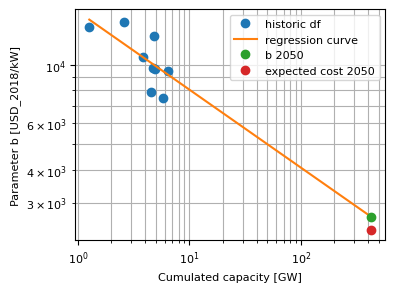

Parameter 1: 15913.447839878267
Parameter 2: -0.2961133555097338
Parameter 3: 78184218.46934895
R^2 = 0.510793
Prospective value of b in 2050: 2649.508
Valid cost in 2050: True


In [50]:
single_regression(df=data, tech="CSP", func = boone, param = "b", p0 = [300, 10, -1], N_param=3)

In [56]:
def multiple_regressions(df, tech, funcs, p0s):
    
    N_params = []
    for i in range(len(p0s)):
        N_params.append(len(p0s[i][0]))
    
    res = pd.DataFrame(columns = ["Tech", "LC", "Parameter", "LC parameters", "Parameter 2050", "R2", "Validity"])
    
    xm = df[df.tech == tech].cap
    ym_a = df[df.tech == tech]["triang_a"]
    ym_b = df[df.tech == tech]["triang_b"]
    
    if (tech == "CSP"):
        xm = df[(df.tech == tech) & (df.year != 2011) & (df.year != 2020)].cap
        ym_a = df[(df.tech == tech) & (df.year != 2011) & (df.year != 2020)]["triang_a"]
        ym_b = df[(df.tech == tech) & (df.year != 2011) & (df.year != 2020)]["triang_b"]
    
    cap_2050 = df[df.tech == tech].cap_2050.iloc[0]
    c_inv_exp_2050 = df[df.tech == tech].c_inv_2050.iloc[0]
    x = np.linspace(min(xm), cap_2050, 3000)
    plt.plot(xm, ym_a, marker='o', ls='none', label="a df", c='r')
    plt.plot(xm, ym_b, marker='o', ls='none', label="b df", c='b')
    
    for i in range(len(funcs)):
        func = funcs[i]
        print(func.__name__)
        N_param = N_params[i]
        p0 = p0s[i]

        popt_a, pcov_a = curve_fit(func, xm, ym_a, p0 = p0[0], maxfev=100000)
        popt_b, pcov_b = curve_fit(func, xm, ym_b, p0 = p0[1], maxfev=100000)

        if N_param == 2:
            reg_a = func(xm, popt_a[0], popt_a[1])
            reg_a_plot = func(x, popt_a[0], popt_a[1])
            c_2050_a = func(cap_2050, popt_a[0], popt_a[1])
            
            reg_b = func(xm, popt_b[0], popt_b[1])
            reg_b_plot = func(x, popt_b[0], popt_b[1])
            c_2050_b = func(cap_2050, popt_b[0], popt_b[1])
            
        elif N_param == 3:
            reg_a = func(xm, popt_a[0], popt_a[1], popt_a[2])
            reg_a_plot = func(x, popt_a[0], popt_a[1], popt_a[2])
            c_2050_a = func(cap_2050, popt_a[0], popt_a[1], popt_a[2])
            
            reg_b = func(xm, popt_b[0], popt_b[1], popt_b[2])
            reg_b_plot = func(x, popt_b[0], popt_b[1], popt_b[2])
            c_2050_b = func(cap_2050, popt_b[0], popt_b[1], popt_b[2])
            
        elif N_param == 4:
            reg_a = func(xm, popt_a[0], popt_a[1], popt_a[2], popt_a[3])
            reg_a_plot = func(x, popt_a[0], popt_a[1], popt_a[2], popt_a[3])
            c_2050_a = func(cap_2050, popt_a[0], popt_a[1], popt_a[2], popt_a[3])
            
            reg_b = func(xm, popt_b[0], popt_b[1], popt_b[2], popt_b[3])
            reg_b_plot = func(x, popt_b[0], popt_b[1], popt_b[2], popt_b[3])
            c_2050_b = func(cap_2050, popt_b[0], popt_b[1], popt_b[2], popt_b[3])

        validity_a = (c_2050_a < c_inv_exp_2050)
        validity_b = (c_2050_b > c_inv_exp_2050)
        
        r_value_a = stats.linregress(ym_a, reg_a)[2]
        r_value_b = stats.linregress(ym_b, reg_b)[2]
        R2_a = round(r_value_a**2, 4) 
        R2_b = round(r_value_b**2, 4) 
        
        res.loc[2*i] = np.array([tech, func.__name__, "a", popt_a.ravel(), c_2050_a, R2_a, validity_a], dtype=object)
        res.loc[2*i+1] = np.array([tech, func.__name__, "b", popt_b.ravel(), c_2050_b, R2_b, validity_b], dtype=object)
        
        color_a = (1-0.1*(i+1), 0.2*(i+1), 0)
        color_b = (0, 0.2*(i+1), 1-0.1*(i+1))
        plt.plot(x, reg_a_plot, label=func.__name__+" a", c = color_a)
        plt.plot(x, reg_b_plot, label=func.__name__+" b", c = color_b)
        #plt.plot(cap_2050, c_2050_a, marker='o', ls='none')
        #plt.plot(cap_2050, c_2050_b, marker='o', ls='none')
        
        plt.xlabel("Cumulated capacity [GW]")
        plt.ylabel('Parameters a & b [USD_2018/kW]')
        
#         for i in range(len(p0)):
#             print("Parameter " + str(i+1) + ":", popt[i])
#         slope, intercept, r_value, p_value, std_err = stats.linregress(ym, reg)
#         r2 = round(r_value**2, 4) 
#         print("R^2 = " + str(r2))
#         print("Prospective value of " + param + " in 2050:", round(c_2050, 3))
        
    plt.loglog()
    plt.grid(which = 'both')
    plt.legend()
    plt.show()
    
    return(res)

wright
boone


C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_1720\415691729.py:69: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i+1] = np.array([tech, func.__name__, "b", popt_b.ravel(), c_2050_b, R2_b, validity_b], dtype=object)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_1720\415691729.py:68: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i] = np.array([tech, func.__name__, "a", popt_a.ravel(), c_2050_a, R2_a, validity_a], dtype=object)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_1720\415691729.py:69: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i+1] = np.ar

sigmoid


C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_1720\415691729.py:68: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i] = np.array([tech, func.__name__, "a", popt_a.ravel(), c_2050_a, R2_a, validity_a], dtype=object)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_1720\415691729.py:69: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i+1] = np.array([tech, func.__name__, "b", popt_b.ravel(), c_2050_b, R2_b, validity_b], dtype=object)


s_curve


C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_1720\415691729.py:68: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i] = np.array([tech, func.__name__, "a", popt_a.ravel(), c_2050_a, R2_a, validity_a], dtype=object)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_1720\415691729.py:69: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i+1] = np.array([tech, func.__name__, "b", popt_b.ravel(), c_2050_b, R2_b, validity_b], dtype=object)


plateau


C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_1720\415691729.py:68: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i] = np.array([tech, func.__name__, "a", popt_a.ravel(), c_2050_a, R2_a, validity_a], dtype=object)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_1720\415691729.py:69: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i+1] = np.array([tech, func.__name__, "b", popt_b.ravel(), c_2050_b, R2_b, validity_b], dtype=object)


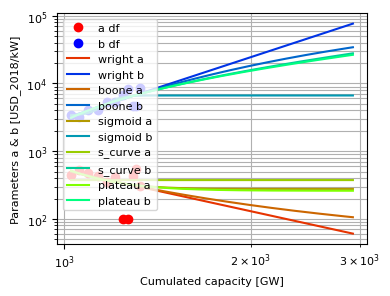

In [57]:
hydro = multiple_regressions(df = data,
                             tech="HYDRO", 
                             funcs=[wright,
                                    boone, 
                                    sigmoid, 
                                    s_curve,
                                    plateau],
                             p0s = [[[10, -1], [10, -1]],
                                    [[30, 500, 1], [30, 500, 1]], 
                                    [[-20000,10,0.001,20000], [-600000,20,-0.001,2000]], 
                                    [[-100,1,0.1,0.001], [-100,1,0.1,0.001]],
                                    [[1000,-0.1,10000], [1000,-0.1,10000]]])

In [58]:
hydro

,Tech,LC,Parameter,LC parameters,Parameter 2050,R2,Validity
0,HYDRO,wright,a,"[20.12601666985672, -2.0073864656036378]",60.682285,0.1912,True
1,HYDRO,wright,b,"[-12.753816764160257, 3.0070076673168447]",76437.817322,0.5337,True
2,HYDRO,boone,a,"[36.9902317103851, 648.7642471063197, 0.5944689433931147]",105.961998,0.1941,True
3,HYDRO,boone,b,"[170134.54698557712, -7400.076958337594, 0.07937425244383384]",34242.302776,0.5355,True
4,HYDRO,sigmoid,a,"[-45456.74677790074, 0.4625468338858026, 0.006621301446954327, 98552.27997600946]",277.374466,0.2028,True
5,HYDRO,sigmoid,b,"[-9.837517140327361e+17, 297888753763475.5, -0.028444034772567427, 6641.76631637273]",6641.766316,0.5475,True
6,HYDRO,s_curve,a,"[2422190.6730529307, 0.0064242331109070445, 21.158435226435383, -167.61265679582553]",374.523241,0.1742,True
7,HYDRO,s_curve,b,"[-780.4890989867782, 1.0101214394107194, 1.0894506727654178, -10.036970003452058]",27843.7929,0.5364,True
8,HYDRO,plateau,a,"[260.34393606947975, -6.406136274976365, 4.946986429130993e+21]",260.653548,0.2007,True
9,HYDRO,plateau,b,"[-11779.478358692435, 0.9016684385657272, 28.67776321184763]",26477.236701,0.5364,True


wright
boone
sigmoid


C:\Users\QQ6354\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


s_curve
plateau


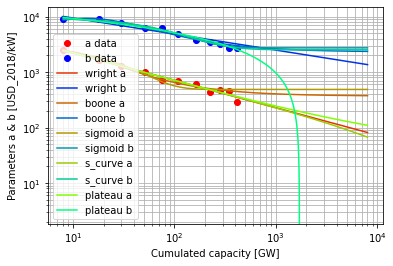

In [19]:
utility_pv = multiple_regressions(tech="UTILITY_PV", 
                     funcs=[wright,
                            boone, 
                            sigmoid, 
                            s_curve,
                            plateau],
                     p0s = [[[10, -1], [10, -1]],
                            [[3000, 500, 0.1], [3000, 500, 0.1]], 
                            [[-100000,100,0.01,10000], [-100000,100,0.01,10000]], 
                            [[10,-1,10000,0.001], [10,-1,10000,0.001]],
                            [[10,-0.1,10000], [10,-0.1,10000]]])

In [20]:
utility_pv

,Tech,LC,Parameter,LC parameters,Parameter 2050,R2,Validity
0,UTILITY_PV,wright,a,"[8.837851704396142, -0.4935640759740477]",81.549005,0.9941,True
1,UTILITY_PV,wright,b,"[9.81749969395595, -0.28927657862456296]",1362.657986,0.9126,True
2,UTILITY_PV,boone,a,"[370.39755771445476, 2.0806881174092466, 6.217616425616543]",375.807002,0.9843,False
3,UTILITY_PV,boone,b,"[2311.4654624595337, 0.8691816345466865, 21.566527903971437]",2360.444522,0.9793,True
4,UTILITY_PV,sigmoid,a,"[-3212956668.963386, 1142.1087647213096, 0.0344549590269791, 2813665.9872608627]",486.745311,0.9652,False
5,UTILITY_PV,sigmoid,b,"[-1231772683.5109107, 421.23754659462577, 0.01088697187608236, 2926909.1846842533]",2733.280924,0.9854,True
6,UTILITY_PV,s_curve,a,"[-1.153251527748159, -0.45457139849546035, 5998.30512393043, -0.005697936818176394]",67.198102,0.9943,True
7,UTILITY_PV,s_curve,b,"[504.17534722454076, -5.766790874014069, 2.783341935284226e+19, 9.055836022071778e-17]",2520.549417,0.9856,True
8,UTILITY_PV,plateau,a,"[39.35406828485117, -0.5125145691350705, 7076.588350070542]",109.991037,0.9942,True
9,UTILITY_PV,plateau,b,"[-14047964.015429711, -0.00012815506192484846, 14061370.8926749]",-2782.296786,0.9651,False


wright
boone
sigmoid
s_curve
plateau


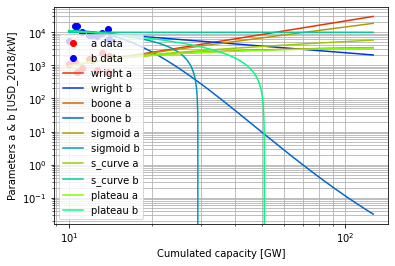

In [21]:
geothermal = multiple_regressions(tech="GEOTHERMAL", 
                     funcs=[wright,
                            boone, 
                            sigmoid, 
                            s_curve,
                            plateau],
                     p0s = [[[10, -1], [10, -1]],
                            [[3000, 500, 0.1], [3000, 500, 0.1]], 
                            [[30000,0.0001,0.2,-200000], [30000,0.0001,0.2,-200000]], 
                            [[10,1,10,0.1], [10,1,10,0.1]],
                            [[100000,-0.1,10000], [100000,-0.1,10000]]])

In [22]:
geothermal

,Tech,LC,Parameter,LC parameters,Parameter 2050,R2,Validity
0,GEOTHERMAL,wright,a,"[3.75049610234005, 1.3528015641644242]",29525.979943,0.1168,False
1,GEOTHERMAL,wright,b,"[10.843293512484742, -0.6667701492318221]",2035.720529,0.0515,False
2,GEOTHERMAL,boone,a,"[3891.4037548140545, 0.7754091214742876, -4.458264878469871]",3391.29846,0.1188,True
3,GEOTHERMAL,boone,b,"[1.774455919277585e-05, 14.630803603098334, 14.960427615796696]",0.032398,0.0714,False
4,GEOTHERMAL,sigmoid,a,"[116921.32622415357, -0.28239415198446516, 0.0006098172296696152, -163375.0243188133]",18279.497223,0.1173,False
5,GEOTHERMAL,sigmoid,b,"[264419.68986799335, -0.43905793395606746, -0.0007017896308084937, -454553.46035626973]",-49867.593562,0.055,False
6,GEOTHERMAL,s_curve,a,"[-5.653786930888859, 0.3418480150426686, 31.615103015734494, -42.515341378406475]",5730.909728,0.1183,True
7,GEOTHERMAL,s_curve,b,"[11321.887690624106, 0.001781549590266999, 3874.6098136680052, -90.69588381530933]",9839.487065,0.055,True
8,GEOTHERMAL,plateau,a,"[3921.3624638780616, -0.6268901953448768, -12697.193622704379]",3309.003554,0.1186,True
9,GEOTHERMAL,plateau,b,"[-2141745.2548746974, -0.0031563864689268454, 2168475.1618128805]",-6120.87104,0.0532,False


wright
boone
sigmoid
s_curve
plateau


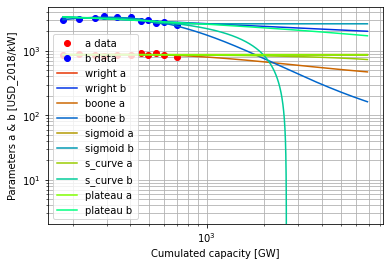

In [23]:
onshore_wind = multiple_regressions(tech="ONSHORE_WIND", 
                     funcs=[wright,
                            boone, 
                            sigmoid, 
                            s_curve,
                            plateau],
                     p0s = [[[10, -1], [10, -1]],
                            [[300, 0.5, 1000], [300, 0.5, 1000]], 
                            [[500,0.01,0.01,5000], [-1000,0.1,0.01,1000]], 
                            [[10,-1,10000,0.001], [10,-1,10000,0.001]],
                            [[10000,-0.1,10000], [10000,-0.1,10000]]])

In [24]:
onshore_wind

,Tech,LC,Parameter,LC parameters,Parameter 2050,R2,Validity
0,ONSHORE_WIND,wright,a,"[6.7858873851937425, -0.0029191173793610818]",862.715994,0.0009,False
1,ONSHORE_WIND,wright,b,"[8.850086369005384, -0.14062154071130173]",2012.52222,0.4069,True
2,ONSHORE_WIND,boone,a,"[326.2491840268207, 0.20373830409126342, 1759.7599073298413]",470.461416,0.1067,True
3,ONSHORE_WIND,boone,b,"[40.344156614378576, 0.9410435137165526, 1384.1145738511839]",162.00145,0.8491,False
4,ONSHORE_WIND,sigmoid,a,"[-1.713410798876589e-06, -0.005273755342926795, 0.007514337393775848, 875.8988701517716]",875.899195,0.2703,False
5,ONSHORE_WIND,sigmoid,b,"[-0.00029966295280576757, 4.727197650046281e-07, 0.03044726336464049, 3261.1053209455567]",2627.192853,0.7924,True
6,ONSHORE_WIND,s_curve,a,"[70415.45724698216, -0.0423839160738061, 23193.384666529237, -1.5524571059761743]",733.277866,0.0098,True
7,ONSHORE_WIND,s_curve,b,"[353029.4328770289, -0.09243743513612973, 11968615.709928356, -0.44262062449298956]",-5872.750623,0.5748,False
8,ONSHORE_WIND,plateau,a,"[-13523.775668104425, -0.0001782187659878157, 14409.069844469539]",862.613997,0.0009,False
9,ONSHORE_WIND,plateau,b,"[-2131628.8770472878, -0.00021299639839270724, 2137361.2861394295]",1712.274699,0.4295,True


wright
boone
sigmoid
s_curve
plateau


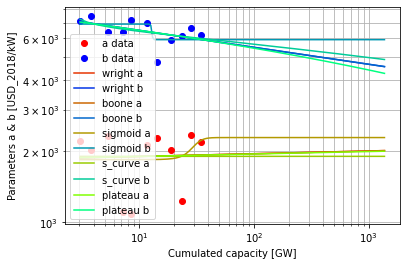

In [25]:
offshore_wind = multiple_regressions(tech="OFFSHORE_WIND", 
                     funcs=[wright,
                            boone, 
                            sigmoid, 
                            s_curve,
                            plateau],
                     p0s = [[[10, -1], [10, -1]],
                            [[300, 0.5, 1000], [300, 0.5, 1000]], 
                            [[500,0.01,0.01,5000], [-1000,0.1,0.01,1000]], 
                            [[1000,-1,1000000,0.001], [20000,0.5,10000,0.5]],
                            [[10000,0.1,10000], [10000,0.1,10000]]])

In [26]:
offshore_wind

,Tech,LC,Parameter,LC parameters,Parameter 2050,R2,Validity
0,OFFSHORE_WIND,wright,a,"[7.522502330463985, 0.011632994775878189]",2011.228283,0.0012,False
1,OFFSHORE_WIND,wright,b,"[8.943536149945022, -0.07179000248483298]",4560.3781,0.2574,True
2,OFFSHORE_WIND,boone,a,"[1849.1848661926524, 0.01163388423035097, 19419142.175128914]",2011.225035,0.0012,False
3,OFFSHORE_WIND,boone,b,"[7658.229008770427, -0.07178995120740952, -467787262.3386328]",4560.372359,0.2574,True
4,OFFSHORE_WIND,sigmoid,a,"[-5085412.5259928005, 11470.384060728522, -0.3236025670371094, 2283.599327953246]",2283.599328,0.0625,False
5,OFFSHORE_WIND,sigmoid,b,"[-7.817304139683355e-49, 8.03632038404706e-52, 9.142354366457926, 6901.537149922762]",5928.790449,0.4694,True
6,OFFSHORE_WIND,s_curve,a,"[5446.251393637009, -1.8502727633956593, 659276.194240711, 0.0028840670851557394]",1901.449861,0.0201,False
7,OFFSHORE_WIND,s_curve,b,"[-2.5896938335292345, 0.003983390499609375, 7015.724284221895, 11.40411887819045]",4886.329667,0.2771,True
8,OFFSHORE_WIND,plateau,a,"[134818.38731154738, -0.000151732331257292, -132965.19820416658]",1998.788173,0.0011,False
9,OFFSHORE_WIND,plateau,b,"[2245841.8054370913, 0.0002025045008169248, -2238296.9938479457]",4269.517443,0.2506,True


wright
boone
sigmoid


C:\Users\QQ6354\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\QQ6354\AppData\Local\Temp\ipykernel_12920\6962530.py:2: RuntimeWarning: overflow encountered in exp
  return a/(b+np.exp(-c*x))+d


s_curve
plateau


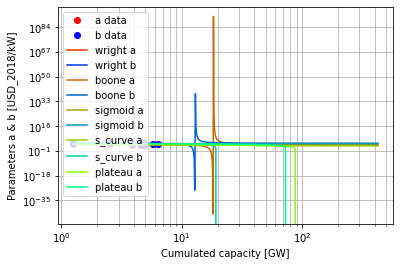

In [159]:
csp = multiple_regressions(tech="CSP", 
                     funcs=[wright,
                            boone, 
                            sigmoid, 
                            s_curve,
                            plateau],
                     p0s = [[[10, -1], [10, -1]],
                            [[300, 0.5, 1000], [300, 0.5, 1000]], 
                            [[-2000,5,0.5,5000], [-200000,5,0.05,50000]], 
                            [[20,-2,1000000,0.01], [20,-2,1000000,0.01]],
                            [[10000,-0.1,10000], [10000,-0.1,10000]]])

In [160]:
csp

,Tech,LC,Parameter,LC parameters,Parameter 2050,R2,Validity
0,CSP,wright,a,"[8.174982186295795, -0.27065388967300386]",689.746837,0.1436,True
1,CSP,wright,b,"[9.67491926872914, -0.29611289710994776]",2649.488002,0.5108,True
2,CSP,boone,a,"[3486.2711553179615, -0.18959987767182435, -18.352512840516436]",3671.17861,0.1537,False
3,CSP,boone,b,"[15180.082451317858, -0.16253612731302247, -12.951867307263251]",15655.79813,0.5523,True
4,CSP,sigmoid,a,"[10065.181429082286, -41.422238778373874, -39.18814542614233, 2465.9044660364525]",2465.904466,0.0,False
5,CSP,sigmoid,b,"[-1.0512441474621047e-25, 2.2666411925951986e-29, 17.460446755446252, 14173.46583471507]",9535.571884,0.6374,True
6,CSP,s_curve,a,"[20.003080306636722, -2.7241598976828647, 12743366.02760345, 2.2568877079746174e-05]",288.376239,0.1774,True
7,CSP,s_curve,b,"[127.57776780683561, -8.5420759308869, 2.283472495344126e+22, -3.095356113901986e-19]",-7068.076186,0.5695,False
8,CSP,plateau,a,"[-2163064.610871278, -0.0003677168690828014, 2166626.675815874]",-1256.172772,0.1556,True
9,CSP,plateau,b,"[-15980784.872784713, -0.00022947685921294244, 15996528.3021633]",-6465.974881,0.5346,False


wright
boone


C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_1720\415691729.py:69: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i+1] = np.array([tech, func.__name__, "b", popt_b.ravel(), c_2050_b, R2_b, validity_b], dtype=object)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_1720\415691729.py:68: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i] = np.array([tech, func.__name__, "a", popt_a.ravel(), c_2050_a, R2_a, validity_a], dtype=object)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_1720\415691729.py:69: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i+1] = np.ar

sigmoid


C:\Users\matthieu.souttre\myenv\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_1720\415691729.py:68: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i] = np.array([tech, func.__name__, "a", popt_a.ravel(), c_2050_a, R2_a, validity_a], dtype=object)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_1720\415691729.py:69: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i+1] = np.array([tech, func.__name__, "b", popt_b.ravel(), c_2050_b, R2_b, validity_b], dtype=object)


s_curve


C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_1720\415691729.py:68: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i] = np.array([tech, func.__name__, "a", popt_a.ravel(), c_2050_a, R2_a, validity_a], dtype=object)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_1720\415691729.py:69: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i+1] = np.array([tech, func.__name__, "b", popt_b.ravel(), c_2050_b, R2_b, validity_b], dtype=object)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_1720\415691729.py:68: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i] = np.arra

plateau


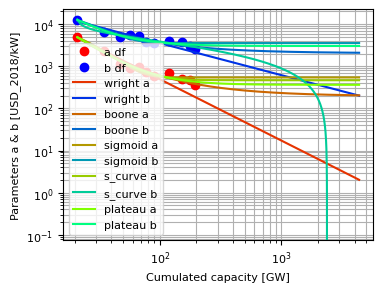

In [68]:
commercial_pv = multiple_regressions(df=data_other,
                                     tech="COMMERCIAL_PV", 
                                     funcs=[wright,
                                            boone, 
                                            sigmoid, 
                                            s_curve,
                                            plateau],
                                     p0s = [[[10, -1], [10, -1]],
                                            [[900, 7000, 0.001], [900, 7000, 0.001]], 
                                            [[-200000,1,0.05,50000], [-200000,1,0.05,50000]], 
                                            [[-20,-0.2,10000,0.01], [-20,-0.2,20000,0.05]],
                                            [[10000,-0.1,10000], [10000,-0.1,10000]]])

In [69]:
commercial_pv

,Tech,LC,Parameter,LC parameters,Parameter 2050,R2,Validity
0,COMMERCIAL_PV,wright,a,"[12.916514512075539, -1.4575975159141326]",2.022553,0.9805,True
1,COMMERCIAL_PV,wright,b,"[11.678635831082048, -0.7608841634728907]",201.087148,0.8997,False
2,COMMERCIAL_PV,boone,a,"[194.91960624592215, 8.929674471076495, 2.826307482650801]",204.618715,0.9909,True
3,COMMERCIAL_PV,boone,b,"[2046.9525325398765, 111656.17685433003, 0.00011173803271563237]",2096.718659,0.9623,True
4,COMMERCIAL_PV,sigmoid,a,"[-544381602.9636889, 176.32655786175104, 0.06639028530104726, 3087892.559882512]",543.668342,0.9912,True
5,COMMERCIAL_PV,sigmoid,b,"[-3134318839.6019907, 302.36736218390047, 0.06351055361764231, 10369486.009808386]",3556.24489,0.9427,True
6,COMMERCIAL_PV,s_curve,a,"[30.010327792085043, -3.932490866060207, 23005337847.06574, 2.0264283597641992e-08]",466.1868,0.9928,True
7,COMMERCIAL_PV,s_curve,b,"[-20.550575138372572, -0.09391377927453529, 11138.22328617161, -0.9321009572957032]",-579.818275,0.977,False
8,COMMERCIAL_PV,plateau,a,"[363.14926041011535, -1.892728556469999, 1446462.576242147]",363.336912,0.9917,True
9,COMMERCIAL_PV,plateau,b,"[3034.1932103387526, -1.7376422125929878, 1914528.16140092]",3035.103981,0.9651,True


wright
boone


C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_1720\415691729.py:69: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i+1] = np.array([tech, func.__name__, "b", popt_b.ravel(), c_2050_b, R2_b, validity_b], dtype=object)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_1720\415691729.py:68: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i] = np.array([tech, func.__name__, "a", popt_a.ravel(), c_2050_a, R2_a, validity_a], dtype=object)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_1720\415691729.py:69: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i+1] = np.ar

sigmoid


C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_1720\415691729.py:68: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i] = np.array([tech, func.__name__, "a", popt_a.ravel(), c_2050_a, R2_a, validity_a], dtype=object)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_1720\415691729.py:69: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i+1] = np.array([tech, func.__name__, "b", popt_b.ravel(), c_2050_b, R2_b, validity_b], dtype=object)


s_curve


C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_1720\415691729.py:68: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i] = np.array([tech, func.__name__, "a", popt_a.ravel(), c_2050_a, R2_a, validity_a], dtype=object)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_1720\415691729.py:69: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i+1] = np.array([tech, func.__name__, "b", popt_b.ravel(), c_2050_b, R2_b, validity_b], dtype=object)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_1720\415691729.py:68: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i] = np.arra

plateau


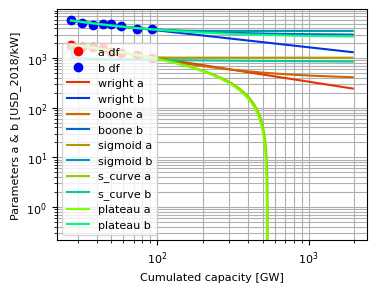

In [76]:
res_pv = multiple_regressions(df=data_other,
                             tech="RES_PV", 
                             funcs=[wright,
                                    boone, 
                                    sigmoid, 
                                    s_curve,
                                    plateau],
                             p0s = [[[10, -1], [10, -1]],
                                    [[900, 7000, 0.001], [900, 7000, 0.001]], 
                                    [[-200000,1,0.05,50000], [-200000,1,0.05,50000]], 
                                    [[-20,-0.2,600,0.1], [-20,-0.2,600,0.1]],
                                    [[1000,-0.1,50000], [1000,-0.1,50000]]])

In [77]:
res_pv

,Tech,LC,Parameter,LC parameters,Parameter 2050,R2,Validity
0,RES_PV,wright,a,"[9.11661564229588, -0.4775287032794639]",244.232826,0.959,True
1,RES_PV,wright,b,"[9.77300414091665, -0.3411552300826857]",1323.30299,0.8568,True
2,RES_PV,boone,a,"[374.41771844455235, 0.9551572898634866, 27.826154796960378]",414.471424,0.9675,True
3,RES_PV,boone,b,"[2938.325032057859, 6631.93610994476, 0.0008427455150506763]",3002.71165,0.8613,True
4,RES_PV,sigmoid,a,"[-48.56869008833625, 0.04527629909927615, 0.07301830803334751, 2098.8040512749394]",1026.086293,0.9712,False
5,RES_PV,sigmoid,b,"[-241023115.18806538, 215.59992959025104, 0.03237432910010019, 1121478.5733586964]",3560.234303,0.8523,True
6,RES_PV,s_curve,a,"[-8.905014389192797, -3.43377558106087e-05, 3481.630414028864, -4644.075629794132]",-723.285727,0.9624,True
7,RES_PV,s_curve,b,"[-26.999999618510127, -0.0557038864638448, 1024.578589135049, 0.525267912279084]",857.343392,0.599,True
8,RES_PV,plateau,a,"[-4669.917628230698, -0.11275905270890871, 9472.728723276166]",-639.054275,0.9639,True
9,RES_PV,plateau,b,"[2640.8561129840323, -0.7893932490532278, 42325.898331903016]",2747.713398,0.8616,True


In [78]:
results_other = pd.concat([res_pv, commercial_pv])

In [29]:
results = pd.concat([utility_pv, res_pv, commercial_pv, csp, onshore_wind, offshore_wind, geothermal, hydro])

In [30]:
results

,Tech,LC,Parameter,LC parameters,Parameter 2050,R2,Validity
0,UTILITY_PV,wright,a,"[8.837851704396142, -0.4935640759740477]",81.549005,0.9941,True
1,UTILITY_PV,wright,b,"[9.81749969395595, -0.28927657862456296]",1362.657986,0.9126,True
2,UTILITY_PV,boone,a,"[370.39755771445476, 2.0806881174092466, 6.217616425616543]",375.807002,0.9843,False
3,UTILITY_PV,boone,b,"[2311.4654624595337, 0.8691816345466865, 21.566527903971437]",2360.444522,0.9793,True
4,UTILITY_PV,sigmoid,a,"[-3212956668.963386, 1142.1087647213096, 0.0344549590269791, 2813665.9872608627]",486.745311,0.9652,False
5,UTILITY_PV,sigmoid,b,"[-1231772683.5109107, 421.23754659462577, 0.01088697187608236, 2926909.1846842533]",2733.280924,0.9854,True
6,UTILITY_PV,s_curve,a,"[-1.153251527748159, -0.45457139849546035, 5998.30512393043, -0.005697936818176394]",67.198102,0.9943,True
7,UTILITY_PV,s_curve,b,"[504.17534722454076, -5.766790874014069, 2.783341935284226e+19, 9.055836022071778e-17]",2520.549417,0.9856,True
8,UTILITY_PV,plateau,a,"[39.35406828485117, -0.5125145691350705, 7076.588350070542]",109.991037,0.9942,True
9,UTILITY_PV,plateau,b,"[-14047964.015429711, -0.00012815506192484846, 14061370.8926749]",-2782.296786,0.9651,False


In [31]:
#results.to_excel("results_triang_prosp_2.xlsx", index=False)

In [79]:
results_other.to_excel("res_triang_other.xlsx", index=False)

In [32]:
data.tech.unique()

array(['UTILITY_PV', 'CSP', 'ONSHORE_WIND', 'OFFSHORE_WIND', 'HYDRO',
       'GEOTHERMAL'], dtype=object)

In [33]:
data

,year,tech,mu,perc_05,perc_95,triang_a,triang_b,triang_c,cap,cap_2050,c_inv_2050
0,2010,UTILITY_PV,4593,3303,7693,2482.755639,8859.276045,4593,8.000,8014.44,371.48
1,2011,UTILITY_PV,3890,2531,7550,1622.694400,8900.222956,3890,18.000,8014.44,371.48
2,2012,UTILITY_PV,2933,2024,6476,1300.431259,7714.271119,2933,30.000,8014.44,371.48
3,2013,UTILITY_PV,2570,1650,5202,1018.142831,6163.506594,2570,51.000,8014.44,371.48
4,2014,UTILITY_PV,2323,1381,5125,722.393380,6142.371964,2323,76.000,8014.44,371.48
...,...,...,...,...,...,...,...,...,...,...,...
83,2016,GEOTHERMAL,3608,2305,6895,1458.897077,8121.120170,3608,12.122,126.00,6682.74
84,2017,GEOTHERMAL,3762,1765,6619,727.868048,7818.150888,3762,12.672,126.00,6682.74
85,2018,GEOTHERMAL,4098,3141,8211,2340.611576,9631.220986,4098,13.148,126.00,6682.74
86,2019,GEOTHERMAL,3852,1986,10085,608.456031,12309.406631,3852,13.862,126.00,6682.74


# Figures : 3 LCs per tech 

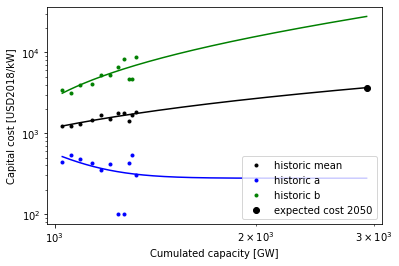

In [14]:
tech = "HYDRO"
color_main = "black"
color_a = "blue"
color_b = "green"
xm = data[data.tech == tech].cap
ym = data[data.tech == tech]["mu"]
ym_a = data[data.tech == tech]["triang_a"]
ym_b = data[data.tech == tech]["triang_b"]
cap_2050 = data[data.tech == tech].cap_2050.iloc[0]
c_inv_exp_2050 = data[data.tech == tech].c_inv_2050.iloc[0]
x = np.linspace(min(xm), cap_2050, 3000)

plt.plot(xm, ym, marker='.', ls='none', label="historic mean", c=color_main)
plt.plot(xm, ym_a, marker='.', ls='none', label="historic a", c=color_a)
plt.plot(xm, ym_b, marker='.', ls='none', label="historic b", c=color_b)

reg = plateau(x=x,a=-5750.07,b=0.286223,c=958.715)
reg_a = sigmoid(x=x, a=-4.54567468e+04, b=4.62546834e-01, c=6.62130145e-03, d=9.85522800e+04)
reg_b = s_curve(x=x, a=-780.48909899, b=1.01012144, c=1.08945067, m=-10.03697)

plt.plot(x, reg, c=color_main)
plt.plot(x, reg_a, c=color_a)
plt.plot(x, reg_b, c=color_b)
# plt.plot(cap_2050, c_2050, marker='o', ls='none', label = param+" 2050")
plt.plot(cap_2050, c_inv_exp_2050, marker = 'o', ls='none', label = "expected cost 2050", c=color_main)
plt.loglog()
#plt.grid()
plt.xlabel("Cumulated capacity [GW]")
plt.ylabel('Capital cost [USD2018/kW]')
plt.legend(loc="lower right")
plt.show()

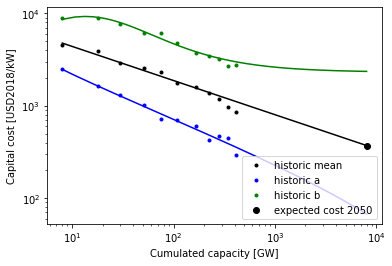

In [15]:
tech = "UTILITY_PV"
color_main = "black"
color_a = "blue"
color_b = "green"
xm = data[data.tech == tech].cap
ym = data[data.tech == tech]["mu"]
ym_a = data[data.tech == tech]["triang_a"]
ym_b = data[data.tech == tech]["triang_b"]
cap_2050 = data[data.tech == tech].cap_2050.iloc[0]
c_inv_exp_2050 = data[data.tech == tech].c_inv_2050.iloc[0]
x = np.linspace(min(xm), cap_2050, 3000)

plt.plot(xm, ym, marker='.', ls='none', label="historic mean", c=color_main)
plt.plot(xm, ym_a, marker='.', ls='none', label="historic a", c=color_a)
plt.plot(xm, ym_b, marker='.', ls='none', label="historic b", c=color_b)

reg = wright(x=x,a=9.2415,b=-0.36979)
reg_a = s_curve(x=x, a=-1.15325153e+00, b=-4.54571398e-01,  c=5.99830512e+03, m=-5.69793682e-03)
reg_b = boone(x=x, a=2.31146546e+03, b=8.69181635e-01, c=2.15665279e+01)

plt.plot(x, reg, c=color_main)
plt.plot(x, reg_a, c=color_a)
plt.plot(x, reg_b, c=color_b)
# plt.plot(cap_2050, c_2050, marker='o', ls='none', label = param+" 2050")
plt.plot(cap_2050, c_inv_exp_2050, marker = 'o', ls='none', label = "expected cost 2050", c=color_main)
plt.loglog()
#plt.grid()
plt.xlabel("Cumulated capacity [GW]")
plt.ylabel('Capital cost [USD2018/kW]')
plt.legend(loc="lower right")
plt.show()

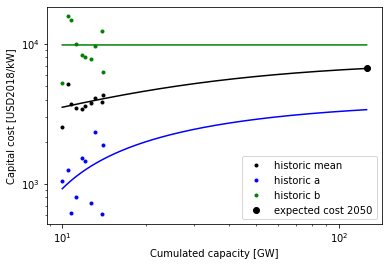

In [24]:
tech = "GEOTHERMAL"
color_main = "black"
color_a = "blue"
color_b = "green"
xm = data[data.tech == tech].cap
ym = data[data.tech == tech]["mu"]
ym_a = data[data.tech == tech]["triang_a"]
ym_b = data[data.tech == tech]["triang_b"]
cap_2050 = data[data.tech == tech].cap_2050.iloc[0]
c_inv_exp_2050 = data[data.tech == tech].c_inv_2050.iloc[0]
x = np.linspace(min(xm), cap_2050, 3000)

plt.plot(xm, ym, marker='.', ls='none', label="historic mean", c=color_main)
plt.plot(xm, ym_a, marker='.', ls='none', label="historic a", c=color_a)
plt.plot(xm, ym_b, marker='.', ls='none', label="historic b", c=color_b) 

reg = boone(x=x,a=7597.11,b=-81.6475,c=0.0409338)
reg_a = boone(x=x, a=3.89140375e+03, b=7.75409121e-01, c=-4.45826488e+00)
reg_b = s_curve(x=x, a=1.13218877e+04, b=1.78154959e-03, c=3.87460981e+03, m=-9.06958838e+01)

plt.plot(x, reg, c=color_main)
plt.plot(x, reg_a, c=color_a)
plt.plot(x, reg_b, c=color_b)
# plt.plot(cap_2050, c_2050, marker='o', ls='none', label = param+" 2050")
plt.plot(cap_2050, c_inv_exp_2050, marker = 'o', ls='none', label = "expected cost 2050", c=color_main)
plt.loglog()
#plt.grid()
plt.xlabel("Cumulated capacity [GW]")
plt.ylabel('Capital cost [USD2018/kW]')
plt.legend(loc="lower right")
plt.show()

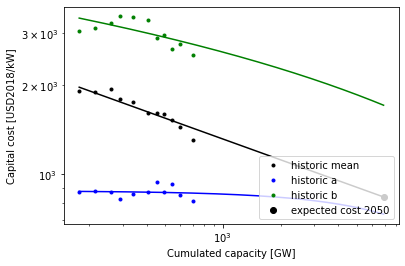

In [28]:
tech = "ONSHORE_WIND"
color_main = "black"
color_a = "blue"
color_b = "green"
xm = data[data.tech == tech].cap
ym = data[data.tech == tech]["mu"]
ym_a = data[data.tech == tech]["triang_a"]
ym_b = data[data.tech == tech]["triang_b"]
cap_2050 = data[data.tech == tech].cap_2050.iloc[0]
c_inv_exp_2050 = data[data.tech == tech].c_inv_2050.iloc[0]
x = np.linspace(min(xm), cap_2050, 3000)

plt.plot(xm, ym, marker='.', ls='none', label="historic mean", c=color_main)
plt.plot(xm, ym_a, marker='.', ls='none', label="historic a", c=color_a)
plt.plot(xm, ym_b, marker='.', ls='none', label="historic b", c=color_b) 

reg = wright(x=x,a=8.7969,b=-0.2337)
reg_a = s_curve(x=x, a=7.04154572e+04, b=-4.23839161e-02, c=2.31933847e+04, m=-1.55245711e+00)
reg_b = plateau(x=x, a=-2.13162888e+06, b=-2.12996398e-04, c=2.13736129e+06)

plt.plot(x, reg, c=color_main)
plt.plot(x, reg_a, c=color_a)
plt.plot(x, reg_b, c=color_b)
# plt.plot(cap_2050, c_2050, marker='o', ls='none', label = param+" 2050")
plt.plot(cap_2050, c_inv_exp_2050, marker = 'o', ls='none', label = "expected cost 2050", c=color_main)
plt.loglog()
#plt.grid()
plt.xlabel("Cumulated capacity [GW]")
plt.ylabel('Capital cost [USD2018/kW]')
plt.legend(loc="lower right")
plt.show()

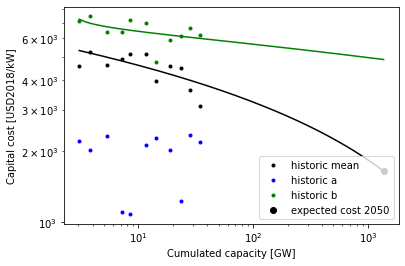

In [33]:
tech = "OFFSHORE_WIND"
color_main = "black"
color_a = "blue"
color_b = "green"
xm = data[data.tech == tech].cap
ym = data[data.tech == tech]["mu"]
ym_a = data[data.tech == tech]["triang_a"]
ym_b = data[data.tech == tech]["triang_b"]
cap_2050 = data[data.tech == tech].cap_2050.iloc[0]
c_inv_exp_2050 = data[data.tech == tech].c_inv_2050.iloc[0]
x = np.linspace(min(xm), cap_2050, 3000)

plt.plot(xm, ym, marker='.', ls='none', label="historic mean", c=color_main)
plt.plot(xm, ym_a, marker='.', ls='none', label="historic a", c=color_a)
plt.plot(xm, ym_b, marker='.', ls='none', label="historic b", c=color_b) 

reg = plateau(x=x,a = -2849200, b = -0.000211753, c = 2855210)
#reg_a = 
reg_b = s_curve(x=x, a=-2.58969383e+00, b=3.98339050e-03, c=7.01572428e+03, m=1.14041189e+01)

plt.plot(x, reg, c=color_main)
#plt.plot(x, reg_a, c=color_a)
plt.plot(x, reg_b, c=color_b)
# plt.plot(cap_2050, c_2050, marker='o', ls='none', label = param+" 2050")
plt.plot(cap_2050, c_inv_exp_2050, marker = 'o', ls='none', label = "expected cost 2050", c=color_main)
plt.loglog()
#plt.grid()
plt.xlabel("Cumulated capacity [GW]")
plt.ylabel('Capital cost [USD2018/kW]')
plt.legend(loc="lower right")
plt.show()

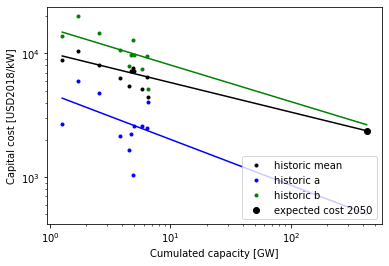

In [173]:
tech = "CSP"
color_main = "black"
color_a = "blue"
color_b = "green"
xm = data[data.tech == tech].cap
ym = data[data.tech == tech]["mu"]
ym_a = data[data.tech == tech]["triang_a"]
ym_b = data[data.tech == tech]["triang_b"]
cap_2050 = data[data.tech == tech].cap_2050.iloc[0]
c_inv_exp_2050 = data[data.tech == tech].c_inv_2050.iloc[0]
x = np.linspace(min(xm), cap_2050, 3000)

plt.plot(xm, ym, marker='.', ls='none', label="historic mean", c=color_main)
plt.plot(xm, ym_a, marker='.', ls='none', label="historic a", c=color_a)
plt.plot(xm, ym_b, marker='.', ls='none', label="historic b", c=color_b) 

reg = wright(x=x,a=9.2176, b=-0.23914)
reg_a = wright(x=x, a=8.46332814, b=-0.3707985)
reg_b = wright(x=x, a=9.67491926872914, b=-0.29611289710994776)

plt.plot(x, reg, c=color_main)
plt.plot(x, reg_a, c=color_a)
plt.plot(x, reg_b, c=color_b)
# plt.plot(cap_2050, c_2050, marker='o', ls='none', label = param+" 2050")
plt.plot(cap_2050, c_inv_exp_2050, marker = 'o', ls='none', label = "expected cost 2050", c=color_main)
plt.loglog()
#plt.grid()
plt.xlabel("Cumulated capacity [GW]")
plt.ylabel('Capital cost [USD2018/kW]')
plt.legend(loc="lower right")
plt.show()

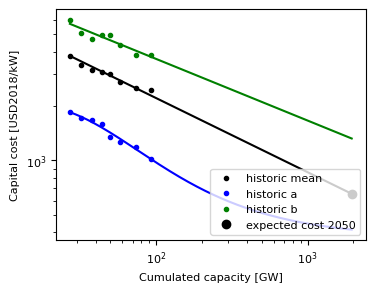

In [81]:
tech = "RES_PV"
color_main = "black"
color_a = "blue"
color_b = "green"
xm = data_other[data_other.tech == tech].cap
ym = data_other[data_other.tech == tech]["mu"]
ym_a = data_other[data_other.tech == tech]["triang_a"]
ym_b = data_other[data_other.tech == tech]["triang_b"]
cap_2050 = data_other[data_other.tech == tech].cap_2050.iloc[0]
c_inv_exp_2050 = data_other[data_other.tech == tech].c_inv_2050.iloc[0]
x = np.linspace(min(xm), cap_2050, 3000)

plt.plot(xm, ym, marker='.', ls='none', label="historic mean", c=color_main)
plt.plot(xm, ym_a, marker='.', ls='none', label="historic a", c=color_a)
plt.plot(xm, ym_b, marker='.', ls='none', label="historic b", c=color_b) 

reg = wright(x=x,a=9.5926, b=-0.41030)
reg_a = boone(x=x, a=374.41771844, b=0.95515729, c=27.8261548)
reg_b = wright(x=x, a=9.77300414, b=-0.34115523)

plt.plot(x, reg, c=color_main)
plt.plot(x, reg_a, c=color_a)
plt.plot(x, reg_b, c=color_b)
# plt.plot(cap_2050, c_2050, marker='o', ls='none', label = param+" 2050")
plt.plot(cap_2050, c_inv_exp_2050, marker = 'o', ls='none', label = "expected cost 2050", c=color_main)
plt.loglog()
#plt.grid()
plt.xlabel("Cumulated capacity [GW]")
plt.ylabel('Capital cost [USD2018/kW]')
plt.legend(loc="lower right")
plt.show()

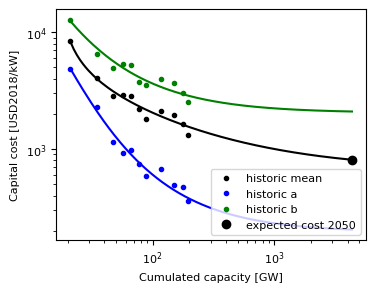

In [86]:
tech = "COMMERCIAL_PV"
color_main = "black"
color_a = "blue"
color_b = "green"
xm = data_other[data_other.tech == tech].cap
ym = data_other[data_other.tech == tech]["mu"]
ym_a = data_other[data_other.tech == tech]["triang_a"]
ym_b = data_other[data_other.tech == tech]["triang_b"]
cap_2050 = data_other[data_other.tech == tech].cap_2050.iloc[0]
c_inv_exp_2050 = data_other[data_other.tech == tech].c_inv_2050.iloc[0]
x = np.linspace(min(xm), cap_2050, 3000)

plt.plot(xm, ym, marker='.', ls='none', label="historic mean", c=color_main)
plt.plot(xm, ym_a, marker='.', ls='none', label="historic a", c=color_a)
plt.plot(xm, ym_b, marker='.', ls='none', label="historic b", c=color_b) 

reg = s_curve(x=x, a = -16.8468, b = -0.574336, c = 18146.3, m = 0.0368012)
reg_a = boone(x=x,a=194.91960625, b=8.92967447, c=2.82630748)
reg_b = boone(x=x, a=2.04695253e+03, b=1.11656177e+05, c=1.11738033e-04)

plt.plot(x, reg, c=color_main)
plt.plot(x, reg_a, c=color_a)
plt.plot(x, reg_b, c=color_b)
# plt.plot(cap_2050, c_2050, marker='o', ls='none', label = param+" 2050")
plt.plot(cap_2050, c_inv_exp_2050, marker = 'o', ls='none', label = "expected cost 2050", c=color_main)
plt.loglog()
#plt.grid()
plt.xlabel("Cumulated capacity [GW]")
plt.ylabel('Capital cost [USD2018/kW]')
plt.legend(loc="lower right")
plt.show()

# Figures : prospesctive points with intervals

In [60]:
plt.rcParams.update({'font.size': 15})

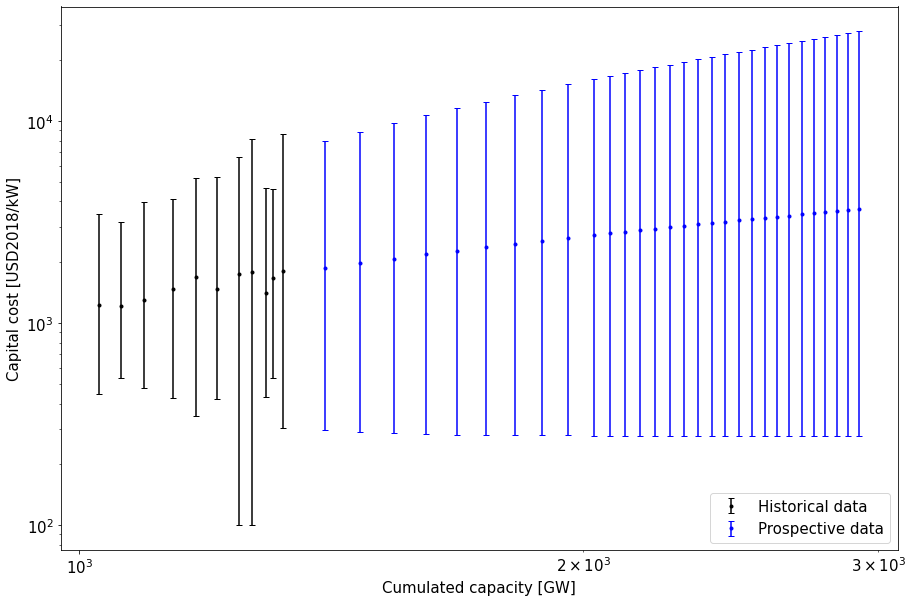

In [63]:
plt.figure(figsize=(15,10))
tech = "HYDRO"
color_main = "black"
color_a = "blue"
color_b = "green"
xm = data[data.tech == tech].cap
ym = data[data.tech == tech]["mu"]
ym_a = data[data.tech == tech]["triang_a"]
ym_b = data[data.tech == tech]["triang_b"]
cap_2050 = data[data.tech == tech].cap_2050.iloc[0]
c_inv_exp_2050 = data[data.tech == tech].c_inv_2050.iloc[0]

x = np.linspace(min(xm), cap_2050, 3000)
x_cap = np.array(pred[(pred.tech == tech) & (2021 <= pred.year) &(pred.year <= 2050)].cap)

# plt.plot(xm, ym, marker='.', ls='none', label="historic mean", c=color_main)
# plt.plot(xm, ym_a, marker='.', ls='none', label="historic a", c=color_a)
# plt.plot(xm, ym_b, marker='.', ls='none', label="historic b", c=color_b)

reg = plateau(x=x,a=-5750.07,b=0.286223,c=958.715)
reg_a = sigmoid(x=x, a=-4.54567468e+04, b=4.62546834e-01, c=6.62130145e-03, d=9.85522800e+04)
reg_b = s_curve(x=x, a=-780.48909899, b=1.01012144, c=1.08945067, m=-10.03697)
# plt.plot(x, reg, c=color_main, alpha=0.5, label="Mean value regression")
# plt.plot(x, reg_a, c=color_a, alpha=0.5, label="Low value regression")
# plt.plot(x, reg_b, c=color_b, alpha=0.5, label="High value regression")

plt.errorbar(xm, ym, yerr=[ym-ym_a, ym_b-ym], 
             color="black", 
             marker=".", 
             ls="",
             ecolor="black",
             elinewidth=1.5,
             capsize=3, label="Historical data")

reg_cap = plateau(x=x_cap,a=-5750.07,b=0.286223,c=958.715)
reg_a_cap = sigmoid(x=x_cap, a=-4.54567468e+04, b=4.62546834e-01, c=6.62130145e-03, d=9.85522800e+04)
reg_b_cap = s_curve(x=x_cap, a=-780.48909899, b=1.01012144, c=1.08945067, m=-10.03697)

plt.errorbar(x_cap, reg_cap, yerr=[reg_cap-reg_a_cap, reg_b_cap-reg_cap],
             color="blue", 
             marker=".", 
             ls="",
             ecolor="blue",
             elinewidth=1.5,
             capsize=3, label="Prospective data")

# plt.plot(x_cap, reg_cap, c=color_main)
# plt.plot(x_cap, reg_a_cap, c=color_a)
# plt.plot(x_cap, reg_b_cap, c=color_b)

# plt.plot(cap_2050, c_2050, marker='o', ls='none', label = param+" 2050")
#plt.plot(cap_2050, c_inv_exp_2050, marker = 'o', ls='none', label = "expected cost 2050", c=color_main)
plt.loglog()
#plt.grid()
plt.xlabel("Cumulated capacity [GW]")
plt.ylabel('Capital cost [USD2018/kW]')
plt.legend(loc="lower right")
plt.savefig("pics/hydro_conf_int.pdf")
plt.show()

# Exporting the data

In [16]:
tech = "HYDRO"

year_hist = list(data[data.tech == tech].year)
N_year_hist = len(year_hist)
cap_hist = list(data[data.tech == tech].cap)
hist_a = list(data[data.tech == tech].triang_a)
hist_b = list(data[data.tech == tech].triang_b)
hist_c = list(data[data.tech == tech].triang_c)

hist = [3*year_hist, 
        3*cap_hist, 
        hist_a+hist_b+hist_c,
        N_year_hist*["a"]+N_year_hist*["b"]+N_year_hist*["c"], 
        3*N_year_hist*["Historical"]]

df_hist = pd.DataFrame(data = np.array(hist).transpose(), columns = ["Year", "Capacity [GW]", "Cost [USD/KW]", "Triangle parameter", "Historical or prospective"])

year_pred = list(range(2021, 2051))
N_year_pred = len(year_pred)
cap_pred = np.array(pred[(pred.tech == tech) & (2021 <= pred.year) &(pred.year <= 2050)].cap)
pred_c = list(plateau(x=cap_pred,a=-5750.07,b=0.286223,c=958.715))
pred_a = list(sigmoid(x=cap_pred, a=-4.54567468e+04, b=4.62546834e-01, c=6.62130145e-03, d=9.85522800e+04))
pred_b = list(s_curve(x=cap_pred, a=-780.48909899, b=1.01012144, c=1.08945067, m=-10.03697))

predic = [3*list(year_pred), 
          3*list(cap_pred), 
          pred_a+pred_b+pred_c,
          N_year_pred*["a"]+N_year_pred*["b"]+N_year_pred*["c"], 
          3*N_year_pred*["Prospective"]]

df_pred = pd.DataFrame(data = np.array(predic).transpose(), columns = ["Year", "Capacity [GW]", "Cost [USD/KW]", "Triangle parameter", "Historical or prospective"])

df_hydro = pd.concat([df_hist, df_pred])

df_hydro.insert(0, "Tech", df_hydro.shape[0]*[tech])

df_hydro.sort_values("Year", inplace=True)
df_hydro.reset_index(drop=True, inplace=True)

In [17]:
tech = "UTILITY_PV"

year_hist = list(data[data.tech == tech].year)
N_year_hist = len(year_hist)
cap_hist = list(data[data.tech == tech].cap)
hist_a = list(data[data.tech == tech].triang_a)
hist_b = list(data[data.tech == tech].triang_b)
hist_c = list(data[data.tech == tech].triang_c)

hist = [3*year_hist, 
        3*cap_hist, 
        hist_a+hist_b+hist_c,
        N_year_hist*["a"]+N_year_hist*["b"]+N_year_hist*["c"], 
        3*N_year_hist*["Historical"]]

df_hist = pd.DataFrame(data = np.array(hist).transpose(), columns = ["Year", "Capacity [GW]", "Cost [USD/KW]", "Triangle parameter", "Historical or prospective"])

year_pred = list(range(2021, 2051))
N_year_pred = len(year_pred)
cap_pred = np.array(pred[(pred.tech == tech) & (2021 <= pred.year) &(pred.year <= 2050)].cap)
pred_c = list(wright(x=cap_pred,a=9.2415,b=-0.36979))
pred_a = list(s_curve(x=cap_pred, a=-1.15325153e+00, b=-4.54571398e-01,  c=5.99830512e+03, m=-5.69793682e-03))
pred_b = list(boone(x=cap_pred, a=2.31146546e+03, b=8.69181635e-01, c=2.15665279e+01))

predic = [3*list(year_pred), 
          3*list(cap_pred), 
          pred_a+pred_b+pred_c,
          N_year_pred*["a"]+N_year_pred*["b"]+N_year_pred*["c"], 
          3*N_year_pred*["Prospective"]]

df_pred = pd.DataFrame(data = np.array(predic).transpose(), columns = ["Year", "Capacity [GW]", "Cost [USD/KW]", "Triangle parameter", "Historical or prospective"])

df_uti_pv = pd.concat([df_hist, df_pred])

df_uti_pv.insert(0, "Tech", df_uti_pv.shape[0]*[tech])

df_uti_pv.sort_values("Year", inplace=True)
df_uti_pv.reset_index(drop=True, inplace=True)

In [18]:
tech = "GEOTHERMAL"

year_hist = list(data[data.tech == tech].year)
N_year_hist = len(year_hist)
cap_hist = list(data[data.tech == tech].cap)
hist_a = list(data[data.tech == tech].triang_a)
hist_b = list(data[data.tech == tech].triang_b)
hist_c = list(data[data.tech == tech].triang_c)

hist = [3*year_hist, 
        3*cap_hist, 
        hist_a+hist_b+hist_c,
        N_year_hist*["a"]+N_year_hist*["b"]+N_year_hist*["c"], 
        3*N_year_hist*["Historical"]]

df_hist = pd.DataFrame(data = np.array(hist).transpose(), columns = ["Year", "Capacity [GW]", "Cost [USD/KW]", "Triangle parameter", "Historical or prospective"])

year_pred = list(range(2021, 2051))
N_year_pred = len(year_pred)
cap_pred = np.array(pred[(pred.tech == tech) & (2021 <= pred.year) &(pred.year <= 2050)].cap)
pred_c = list(boone(x=cap_pred,a=7597.11,b=-81.6475,c=0.0409338))
pred_a = list(boone(x=cap_pred, a=3.89140375e+03, b=7.75409121e-01, c=-4.45826488e+00))
pred_b = list(s_curve(x=cap_pred, a=1.13218877e+04, b=1.78154959e-03, c=3.87460981e+03, m=-9.06958838e+01))

predic = [3*list(year_pred), 
          3*list(cap_pred), 
          pred_a+pred_b+pred_c,
          N_year_pred*["a"]+N_year_pred*["b"]+N_year_pred*["c"], 
          3*N_year_pred*["Prospective"]]

df_pred = pd.DataFrame(data = np.array(predic).transpose(), columns = ["Year", "Capacity [GW]", "Cost [USD/KW]", "Triangle parameter", "Historical or prospective"])

df_geoth = pd.concat([df_hist, df_pred])

df_geoth.insert(0, "Tech", df_geoth.shape[0]*[tech])

df_geoth.sort_values("Year", inplace=True)
df_geoth.reset_index(drop=True, inplace=True)

In [19]:
tech = "ONSHORE_WIND"

year_hist = list(data[data.tech == tech].year)
N_year_hist = len(year_hist)
cap_hist = list(data[data.tech == tech].cap)
hist_a = list(data[data.tech == tech].triang_a)
hist_b = list(data[data.tech == tech].triang_b)
hist_c = list(data[data.tech == tech].triang_c)

hist = [3*year_hist, 
        3*cap_hist, 
        hist_a+hist_b+hist_c,
        N_year_hist*["a"]+N_year_hist*["b"]+N_year_hist*["c"], 
        3*N_year_hist*["Historical"]]

df_hist = pd.DataFrame(data = np.array(hist).transpose(), columns = ["Year", "Capacity [GW]", "Cost [USD/KW]", "Triangle parameter", "Historical or prospective"])

year_pred = list(range(2021, 2051))
N_year_pred = len(year_pred)
cap_pred = np.array(pred[(pred.tech == tech) & (2021 <= pred.year) &(pred.year <= 2050)].cap)
pred_c = list(wright(x=cap_pred,a=8.7969,b=-0.2337))
pred_a = list(s_curve(x=cap_pred, a=7.04154572e+04, b=-4.23839161e-02, c=2.31933847e+04, m=-1.55245711e+00))
pred_b = list(plateau(x=cap_pred, a=-2.13162888e+06, b=-2.12996398e-04, c=2.13736129e+06))

predic = [3*list(year_pred), 
          3*list(cap_pred), 
          pred_a+pred_b+pred_c,
          N_year_pred*["a"]+N_year_pred*["b"]+N_year_pred*["c"], 
          3*N_year_pred*["Prospective"]]

df_pred = pd.DataFrame(data = np.array(predic).transpose(), columns = ["Year", "Capacity [GW]", "Cost [USD/KW]", "Triangle parameter", "Historical or prospective"])

df_onshore_wind = pd.concat([df_hist, df_pred])

df_onshore_wind.insert(0, "Tech", df_onshore_wind.shape[0]*[tech])

df_onshore_wind.sort_values("Year", inplace=True)
df_onshore_wind.reset_index(drop=True, inplace=True)

In [20]:
tech = "OFFSHORE_WIND"

year_hist = list(data[data.tech == tech].year)
N_year_hist = len(year_hist)
cap_hist = list(data[data.tech == tech].cap)
hist_a = list(data[data.tech == tech].triang_a)
hist_b = list(data[data.tech == tech].triang_b)
hist_c = list(data[data.tech == tech].triang_c)

hist = [3*year_hist, 
        3*cap_hist, 
        hist_a+hist_b+hist_c,
        N_year_hist*["a"]+N_year_hist*["b"]+N_year_hist*["c"], 
        3*N_year_hist*["Historical"]]

df_hist = pd.DataFrame(data = np.array(hist).transpose(), columns = ["Year", "Capacity [GW]", "Cost [USD/KW]", "Triangle parameter", "Historical or prospective"])

year_pred = list(range(2021, 2051))
N_year_pred = len(year_pred)
cap_pred = np.array(pred[(pred.tech == tech) & (2021 <= pred.year) &(pred.year <= 2050)].cap)
pred_c = list(plateau(x=cap_pred,a = -2849200, b = -0.000211753, c = 2855210))
pred_a = N_year_pred*[min(hist_a)]
pred_b = list(s_curve(x=cap_pred, a=-2.58969383e+00, b=3.98339050e-03, c=7.01572428e+03, m=1.14041189e+01))

predic = [3*list(year_pred), 
          3*list(cap_pred), 
          pred_a+pred_b+pred_c,
          N_year_pred*["a"]+N_year_pred*["b"]+N_year_pred*["c"], 
          3*N_year_pred*["Prospective"]]

df_pred = pd.DataFrame(data = np.array(predic).transpose(), columns = ["Year", "Capacity [GW]", "Cost [USD/KW]", "Triangle parameter", "Historical or prospective"])

df_offshore_wind = pd.concat([df_hist, df_pred])

df_offshore_wind.insert(0, "Tech", df_offshore_wind.shape[0]*[tech])

df_offshore_wind.sort_values("Year", inplace=True)
df_offshore_wind.reset_index(drop=True, inplace=True)

In [175]:
tech = "CSP"

year_hist = list(data[data.tech == tech].year)
N_year_hist = len(year_hist)
cap_hist = list(data[data.tech == tech].cap)
hist_a = list(data[data.tech == tech].triang_a)
hist_b = list(data[data.tech == tech].triang_b)
hist_c = list(data[data.tech == tech].triang_c)

hist = [3*year_hist, 
        3*cap_hist, 
        hist_a+hist_b+hist_c,
        N_year_hist*["a"]+N_year_hist*["b"]+N_year_hist*["c"], 
        3*N_year_hist*["Historical"]]

df_hist = pd.DataFrame(data = np.array(hist).transpose(), columns = ["Year", "Capacity [GW]", "Cost [USD/KW]", "Triangle parameter", "Historical or prospective"])

year_pred = list(range(2021, 2051))
N_year_pred = len(year_pred)
cap_pred = np.array(pred[(pred.tech == tech) & (2021 <= pred.year) & (pred.year <= 2050)].cap)
pred_c = list(wright(x=cap_pred,a=9.2176, b=-0.23914))
pred_a = list(wright(x=cap_pred, a=8.46332814, b=-0.3707985))
pred_b = list(wright(x=cap_pred, a=9.67491926872914, b=-0.29611289710994776))

predic = [3*list(year_pred), 
          3*list(cap_pred), 
          pred_a+pred_b+pred_c,
          N_year_pred*["a"]+N_year_pred*["b"]+N_year_pred*["c"], 
          3*N_year_pred*["Prospective"]]

df_pred = pd.DataFrame(data = np.array(predic).transpose(), columns = ["Year", "Capacity [GW]", "Cost [USD/KW]", "Triangle parameter", "Historical or prospective"])

df_csp = pd.concat([df_hist, df_pred])

df_csp.insert(0, "Tech", df_csp.shape[0]*[tech])

df_csp.sort_values("Year", inplace=True)
df_csp.reset_index(drop=True, inplace=True)

In [91]:
tech = "RES_PV"

year_hist = list(data_other[data_other.tech == tech].year)
N_year_hist = len(year_hist)
cap_hist = list(data_other[data_other.tech == tech].cap)
hist_a = list(data_other[data_other.tech == tech].triang_a)
hist_b = list(data_other[data_other.tech == tech].triang_b)
hist_c = list(data_other[data_other.tech == tech].triang_c)

hist = [3*year_hist, 
        3*cap_hist, 
        hist_a+hist_b+hist_c,
        N_year_hist*["a"]+N_year_hist*["b"]+N_year_hist*["c"], 
        3*N_year_hist*["Historical"]]

df_hist = pd.DataFrame(data = np.array(hist).transpose(), columns = ["Year", "Capacity [GW]", "Cost [USD/KW]", "Triangle parameter", "Historical or prospective"])

year_pred = list(range(2021, 2051))
N_year_pred = len(year_pred)
cap_pred = np.array(pred[(pred.tech == tech) & (2021 <= pred.year) & (pred.year <= 2050)].cap)
pred_c = list(wright(x=cap_pred,a=9.5926, b=-0.41030))
pred_a = list(boone(x=cap_pred, a=374.41771844, b=0.95515729, c=27.8261548))
pred_b = list(wright(x=cap_pred, a=9.77300414, b=-0.34115523))

predic = [3*list(year_pred), 
          3*list(cap_pred), 
          pred_a+pred_b+pred_c,
          N_year_pred*["a"]+N_year_pred*["b"]+N_year_pred*["c"], 
          3*N_year_pred*["Prospective"]]

df_pred = pd.DataFrame(data = np.array(predic).transpose(), columns = ["Year", "Capacity [GW]", "Cost [USD/KW]", "Triangle parameter", "Historical or prospective"])

df_res_pv = pd.concat([df_hist, df_pred])

df_res_pv.insert(0, "Tech", df_res_pv.shape[0]*[tech])

df_res_pv.sort_values("Year", inplace=True)
df_res_pv.reset_index(drop=True, inplace=True)

In [93]:
tech = "COMMERCIAL_PV"

year_hist = list(data_other[data_other.tech == tech].year)
N_year_hist = len(year_hist)
cap_hist = list(data_other[data_other.tech == tech].cap)
hist_a = list(data_other[data_other.tech == tech].triang_a)
hist_b = list(data_other[data_other.tech == tech].triang_b)
hist_c = list(data_other[data_other.tech == tech].triang_c)

hist = [3*year_hist, 
        3*cap_hist, 
        hist_a+hist_b+hist_c,
        N_year_hist*["a"]+N_year_hist*["b"]+N_year_hist*["c"], 
        3*N_year_hist*["Historical"]]

df_hist = pd.DataFrame(data = np.array(hist).transpose(), columns = ["Year", "Capacity [GW]", "Cost [USD/KW]", "Triangle parameter", "Historical or prospective"])

year_pred = list(range(2021, 2051))
N_year_pred = len(year_pred)
cap_pred = np.array(pred[(pred.tech == tech) & (2021 <= pred.year) & (pred.year <= 2050)].cap)
pred_c = list(s_curve(x=cap_pred, a = -16.8468, b = -0.574336, c = 18146.3, m = 0.0368012))
pred_a = list(boone(x=cap_pred,a=194.91960625, b=8.92967447, c=2.82630748))
pred_b = list(boone(x=cap_pred, a=2.04695253e+03, b=1.11656177e+05, c=1.11738033e-04))

predic = [3*list(year_pred), 
          3*list(cap_pred), 
          pred_a+pred_b+pred_c,
          N_year_pred*["a"]+N_year_pred*["b"]+N_year_pred*["c"], 
          3*N_year_pred*["Prospective"]]

df_pred = pd.DataFrame(data = np.array(predic).transpose(), columns = ["Year", "Capacity [GW]", "Cost [USD/KW]", "Triangle parameter", "Historical or prospective"])

df_com_pv = pd.concat([df_hist, df_pred])

df_com_pv.insert(0, "Tech", df_com_pv.shape[0]*[tech])

df_com_pv.sort_values("Year", inplace=True)
df_com_pv.reset_index(drop=True, inplace=True)

In [94]:
df_all_other = pd.concat([df_res_pv, df_com_pv])

In [176]:
df_all = pd.concat([df_uti_pv, df_res_pv, df_com_pv, df_onshore_wind, df_offshore_wind, df_hydro, df_geoth, df_csp])

In [177]:
df_all.to_excel("results_with_CI.xlsx", index=False)

In [96]:
#df_all_other.to_excel("results_with_CI_2.xlsx", index=False)